# Case strudy: Cancer Classification in Clinical data from the MIMIC-II database for a case study on indwelling arterial catheters

## Problem definition

- Predicting if patients have a malignant tumor base on demographic data (e.g. age, weight), clinical observations collected during the first day of ICU stay (e.g. white blood cell count, heart rate), and outcomes (e.g. 28 day mortality and length of stay).

- 46 features are used, examples:
      - aline_flg: Indwelling arterial catheters (IACs) used (binary, 1 = year, 0 = no)
      - icu_los_day: length of stay in ICU (days, numeric)
      - hospital_los_day: length of stay in hospital (days, numeric)
      - age: age at baseline (years, numeric)
      - gender_num: patient gender (1 = male; 0=female)
      - weight_first: first weight, (kg, numeric)
      - bmi: patient BMI, (numeric)
      - sapsi_first: first SAPS I score (numeric)
      - sofa_first: first SOFA score (numeric)


- Datasets are linearly separable using all 46 input features
- Number of Instances: 1776
- Class Distribution: 256 Malignant, 1520 Normal
- Target class (mal_flag):
         - Normal = 0
         - Malignant = 1







### Bibliogrphy
- Raffa, J. (2016). Clinical data from the MIMIC-II database for a case study on indwelling arterial catheters (version 1.0). PhysioNet. https://doi.org/10.13026/C2NC7F.

- Data, M. C. (2016). Secondary analysis of electronic health records. En Springer eBooks. https://doi.org/10.1007/978-3-319-43742-2

- Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

- Kulin-Patel. (s. f.). Breast-cancer-classification/breast _cancer_classification.ipynb at main · kulin-patel/breast-cancer-classification. GitHub. https://github.com/kulin-patel/breast-cancer-classification/blob/main/breast%20_cancer_classification.ipynb

## Importing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix

import joblib
from joblib import dump, load

!pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE

from random import randint



!wget -r -N -c -np https://physionet.org/files/mimic2-iaccd/1.0/
table = pd.read_csv('/content/physionet.org/files/mimic2-iaccd/1.0/full_cohort_data.csv')


--2023-10-04 17:59:59--  https://physionet.org/files/mimic2-iaccd/1.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/mimic2-iaccd/1.0/index.html’

physionet.org/files     [ <=>                ]     835  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2023-10-04 18:00:00 (237 MB/s) - ‘physionet.org/files/mimic2-iaccd/1.0/index.html’ saved [835]

Loading robots.txt; please ignore errors.
--2023-10-04 18:00:00--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.

--2023-10-04 18:00:00--  https://physionet.org/files/mimic2-iaccd/1.0/LICENSE.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response..

In [2]:
table

aline_flg  icu_los_day  hospital_los_day       age  gender_num  \
0             1         7.63                13  72.36841         1.0   
1             0         1.14                 1  64.92076         0.0   
2             0         2.86                 5  36.50000         0.0   
3             1         0.58                 3  44.49191         0.0   
4             1         1.75                 5  23.74217         1.0   
...         ...          ...               ...       ...         ...   
1771          1        26.90                31  68.48606         1.0   
1772          1         3.70                 4  72.44020         0.0   
1773          0         2.87                 3  22.70098         1.0   
1774          1        22.63                23  53.74423         1.0   
1775          1         2.08                10  60.87331         0.0   

      weight_first        bmi  sapsi_first  sofa_first service_unit  ...  \
0             75.0  29.912791         15.0         9.0         SICU  ...   
1             55.0  20.121312          NaN         5.0         MICU  ...   
2             70.0  27.118272         16.0         5.0         MICU  ...   
3              NaN        NaN         21.0         7.0         SICU  ...   
4             95.2  28.464563         18.0         7.0         SICU  ...   
...            ...        ...          ...         ...          ...  ...   
1771          76.6        NaN         17.0         8.0         MICU  ...   
1772          60.0        NaN         14.0         5.0         SICU  ...   
1773          69.0        NaN         16.0         5.0         MICU  ...   
1774         124.4        NaN         18.0         9.0         SICU  ...   
1775          65.4        NaN         14.0         7.0         MICU  ...   

      platelet_first sodium_first  potassium_first  tco2_first  \
0              354.0        138.0              4.6        15.0   
1                NaN          NaN              NaN         NaN   
2              295.0        144.0              3.9        17.0   
3              262.0        139.0              4.2        31.0   
4               22.0        146.0              3.4        19.0   
...              ...          ...              ...         ...   
1771           294.0        135.0              3.4        23.0   
1772           363.0        138.0              6.3        22.0   
1773           121.0        134.0              4.1        23.0   
1774           374.0        137.0              4.6        21.0   
1775           226.0        139.0              3.9         3.0   

      chloride_first  bun_first  creatinine_first  po2_first  pco2_first  \
0              109.0       41.0               1.6      196.0        39.0   
1                NaN        NaN               NaN        NaN         NaN   
2              101.0       16.0               0.8      298.0        30.0   
3              100.0       16.0               0.5      146.0        23.0   
4              110.0       10.0               1.0      134.0        30.0   
...              ...        ...               ...        ...         ...   
1771           100.0       17.0               0.9      253.0        35.0   
1772           104.0       20.0               0.8      154.0        45.0   
1773           105.0       27.0               0.6        NaN         NaN   
1774            99.0       13.0               1.1       84.0        31.0   
1775           111.0       25.0               1.4      574.0        12.0   

         iv_day_1  
0     2230.875000  
1      600.000000  
2     2086.800293  
3             NaN  
4     2358.244141  
...           ...  
1771   100.117500  
1772   289.950012  
1773   157.500000  
1774    21.770000  
1775  4368.000000  

[1776 rows x 46 columns]

In [3]:
table.keys()

Index(['aline_flg', 'icu_los_day', 'hospital_los_day', 'age', 'gender_num',
       'weight_first', 'bmi', 'sapsi_first', 'sofa_first', 'service_unit',
       'service_num', 'day_icu_intime', 'day_icu_intime_num',
       'hour_icu_intime', 'hosp_exp_flg', 'icu_exp_flg', 'day_28_flg',
       'mort_day_censored', 'censor_flg', 'sepsis_flg', 'chf_flg', 'afib_flg',
       'renal_flg', 'liver_flg', 'copd_flg', 'cad_flg', 'stroke_flg',
       'mal_flg', 'resp_flg', 'map_1st', 'hr_1st', 'temp_1st', 'spo2_1st',
       'abg_count', 'wbc_first', 'hgb_first', 'platelet_first', 'sodium_first',
       'potassium_first', 'tco2_first', 'chloride_first', 'bun_first',
       'creatinine_first', 'po2_first', 'pco2_first', 'iv_day_1'],
      dtype='object')

In [4]:
table.shape

(1776, 46)

In [5]:
table['mal_flg']

0       1
1       0
2       0
3       1
4       0
       ..
1771    0
1772    1
1773    1
1774    0
1775    0
Name: mal_flg, Length: 1776, dtype: int64

### Drop mal_flg variable

In [6]:
data=table.drop(['mal_flg'],axis=1)
label=table['mal_flg']

In [7]:
data.keys()

Index(['aline_flg', 'icu_los_day', 'hospital_los_day', 'age', 'gender_num',
       'weight_first', 'bmi', 'sapsi_first', 'sofa_first', 'service_unit',
       'service_num', 'day_icu_intime', 'day_icu_intime_num',
       'hour_icu_intime', 'hosp_exp_flg', 'icu_exp_flg', 'day_28_flg',
       'mort_day_censored', 'censor_flg', 'sepsis_flg', 'chf_flg', 'afib_flg',
       'renal_flg', 'liver_flg', 'copd_flg', 'cad_flg', 'stroke_flg',
       'resp_flg', 'map_1st', 'hr_1st', 'temp_1st', 'spo2_1st', 'abg_count',
       'wbc_first', 'hgb_first', 'platelet_first', 'sodium_first',
       'potassium_first', 'tco2_first', 'chloride_first', 'bun_first',
       'creatinine_first', 'po2_first', 'pco2_first', 'iv_day_1'],
      dtype='object')

In [8]:
data

aline_flg  icu_los_day  hospital_los_day       age  gender_num  \
0             1         7.63                13  72.36841         1.0   
1             0         1.14                 1  64.92076         0.0   
2             0         2.86                 5  36.50000         0.0   
3             1         0.58                 3  44.49191         0.0   
4             1         1.75                 5  23.74217         1.0   
...         ...          ...               ...       ...         ...   
1771          1        26.90                31  68.48606         1.0   
1772          1         3.70                 4  72.44020         0.0   
1773          0         2.87                 3  22.70098         1.0   
1774          1        22.63                23  53.74423         1.0   
1775          1         2.08                10  60.87331         0.0   

      weight_first        bmi  sapsi_first  sofa_first service_unit  ...  \
0             75.0  29.912791         15.0         9.0         SICU  ...   
1             55.0  20.121312          NaN         5.0         MICU  ...   
2             70.0  27.118272         16.0         5.0         MICU  ...   
3              NaN        NaN         21.0         7.0         SICU  ...   
4             95.2  28.464563         18.0         7.0         SICU  ...   
...            ...        ...          ...         ...          ...  ...   
1771          76.6        NaN         17.0         8.0         MICU  ...   
1772          60.0        NaN         14.0         5.0         SICU  ...   
1773          69.0        NaN         16.0         5.0         MICU  ...   
1774         124.4        NaN         18.0         9.0         SICU  ...   
1775          65.4        NaN         14.0         7.0         MICU  ...   

      platelet_first sodium_first  potassium_first  tco2_first  \
0              354.0        138.0              4.6        15.0   
1                NaN          NaN              NaN         NaN   
2              295.0        144.0              3.9        17.0   
3              262.0        139.0              4.2        31.0   
4               22.0        146.0              3.4        19.0   
...              ...          ...              ...         ...   
1771           294.0        135.0              3.4        23.0   
1772           363.0        138.0              6.3        22.0   
1773           121.0        134.0              4.1        23.0   
1774           374.0        137.0              4.6        21.0   
1775           226.0        139.0              3.9         3.0   

      chloride_first  bun_first  creatinine_first  po2_first  pco2_first  \
0              109.0       41.0               1.6      196.0        39.0   
1                NaN        NaN               NaN        NaN         NaN   
2              101.0       16.0               0.8      298.0        30.0   
3              100.0       16.0               0.5      146.0        23.0   
4              110.0       10.0               1.0      134.0        30.0   
...              ...        ...               ...        ...         ...   
1771           100.0       17.0               0.9      253.0        35.0   
1772           104.0       20.0               0.8      154.0        45.0   
1773           105.0       27.0               0.6        NaN         NaN   
1774            99.0       13.0               1.1       84.0        31.0   
1775           111.0       25.0               1.4      574.0        12.0   

         iv_day_1  
0     2230.875000  
1      600.000000  
2     2086.800293  
3             NaN  
4     2358.244141  
...           ...  
1771   100.117500  
1772   289.950012  
1773   157.500000  
1774    21.770000  
1775  4368.000000  

[1776 rows x 45 columns]

### Create a Dataframe

In [9]:
df=pd.DataFrame(np.c_[data,label],columns=np.append(data.keys(),'cancer'))
df

aline_flg icu_los_day hospital_los_day       age gender_num weight_first  \
0            1        7.63               13  72.36841        1.0         75.0   
1            0        1.14                1  64.92076        0.0         55.0   
2            0        2.86                5      36.5        0.0         70.0   
3            1        0.58                3  44.49191        0.0          NaN   
4            1        1.75                5  23.74217        1.0         95.2   
...        ...         ...              ...       ...        ...          ...   
1771         1        26.9               31  68.48606        1.0         76.6   
1772         1         3.7                4   72.4402        0.0         60.0   
1773         0        2.87                3  22.70098        1.0         69.0   
1774         1       22.63               23  53.74423        1.0        124.4   
1775         1        2.08               10  60.87331        0.0         65.4   

            bmi sapsi_first sofa_first service_unit  ... sodium_first  \
0     29.912791        15.0        9.0         SICU  ...        138.0   
1     20.121312         NaN        5.0         MICU  ...          NaN   
2     27.118272        16.0        5.0         MICU  ...        144.0   
3           NaN        21.0        7.0         SICU  ...        139.0   
4     28.464563        18.0        7.0         SICU  ...        146.0   
...         ...         ...        ...          ...  ...          ...   
1771        NaN        17.0        8.0         MICU  ...        135.0   
1772        NaN        14.0        5.0         SICU  ...        138.0   
1773        NaN        16.0        5.0         MICU  ...        134.0   
1774        NaN        18.0        9.0         SICU  ...        137.0   
1775        NaN        14.0        7.0         MICU  ...        139.0   

     potassium_first tco2_first chloride_first bun_first creatinine_first  \
0                4.6       15.0          109.0      41.0              1.6   
1                NaN        NaN            NaN       NaN              NaN   
2                3.9       17.0          101.0      16.0              0.8   
3                4.2       31.0          100.0      16.0              0.5   
4                3.4       19.0          110.0      10.0              1.0   
...              ...        ...            ...       ...              ...   
1771             3.4       23.0          100.0      17.0              0.9   
1772             6.3       22.0          104.0      20.0              0.8   
1773             4.1       23.0          105.0      27.0              0.6   
1774             4.6       21.0           99.0      13.0              1.1   
1775             3.9        3.0          111.0      25.0              1.4   

     po2_first pco2_first     iv_day_1 cancer  
0        196.0       39.0     2230.875      1  
1          NaN        NaN        600.0      0  
2        298.0       30.0  2086.800293      0  
3        146.0       23.0          NaN      1  
4        134.0       30.0  2358.244141      0  
...        ...        ...          ...    ...  
1771     253.0       35.0     100.1175      0  
1772     154.0       45.0   289.950012      1  
1773       NaN        NaN        157.5      1  
1774      84.0       31.0        21.77      0  
1775     574.0       12.0       4368.0      0  

[1776 rows x 46 columns]

# Preprocessing Data

## Checking of empty variables

In [10]:
df.any()

aline_flg              True
icu_los_day            True
hospital_los_day       True
age                    True
gender_num             True
weight_first           True
bmi                    True
sapsi_first            True
sofa_first             True
service_unit           True
service_num            True
day_icu_intime         True
day_icu_intime_num     True
hour_icu_intime        True
hosp_exp_flg           True
icu_exp_flg            True
day_28_flg             True
mort_day_censored      True
censor_flg             True
sepsis_flg            False
chf_flg                True
afib_flg               True
renal_flg              True
liver_flg              True
copd_flg               True
cad_flg                True
stroke_flg             True
resp_flg               True
map_1st                True
hr_1st                 True
temp_1st               True
spo2_1st               True
abg_count              True
wbc_first              True
hgb_first              True
platelet_first      

## Correct Data

In [11]:
class CustomTransform(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Copies the DataFrame to avoid modifying the original one
        X_transformado = X.copy()

        # Map service_unit categories to numbers
        X_transformado['service_unit'].replace({'MICU': 0, 'SICU': 1, 'FICU': 2}, inplace=True)

        # Remove columns 'day_icu_intime' and 'sepsis_flg'.
        X_transformado = X_transformado.drop(['day_icu_intime', 'sepsis_flg'], axis=1)

        try:
            #Create DataFrame as in the previous steps
            X_transformado = pd.DataFrame(np.c_[X_transformado, X_transformado['mal_flg']], columns=np.append(X_transformado.keys(),'cancer'))
            X_transformado = X_transformado.drop(['mal_flg'],axis=1)

        except:
            print('Ther is no mal_flg')

        return X_transformado



# Create an instance of the custom transformation
MyTransformation = CustomTransform()

# Apply the transformation to the DataFrame
df_transf = MyTransformation.transform(df)
df_transf


Ther is no mal_flg


aline_flg icu_los_day hospital_los_day       age gender_num weight_first  \
0            1        7.63               13  72.36841        1.0         75.0   
1            0        1.14                1  64.92076        0.0         55.0   
2            0        2.86                5      36.5        0.0         70.0   
3            1        0.58                3  44.49191        0.0          NaN   
4            1        1.75                5  23.74217        1.0         95.2   
...        ...         ...              ...       ...        ...          ...   
1771         1        26.9               31  68.48606        1.0         76.6   
1772         1         3.7                4   72.4402        0.0         60.0   
1773         0        2.87                3  22.70098        1.0         69.0   
1774         1       22.63               23  53.74423        1.0        124.4   
1775         1        2.08               10  60.87331        0.0         65.4   

            bmi sapsi_first sofa_first  service_unit  ... sodium_first  \
0     29.912791        15.0        9.0             1  ...        138.0   
1     20.121312         NaN        5.0             0  ...          NaN   
2     27.118272        16.0        5.0             0  ...        144.0   
3           NaN        21.0        7.0             1  ...        139.0   
4     28.464563        18.0        7.0             1  ...        146.0   
...         ...         ...        ...           ...  ...          ...   
1771        NaN        17.0        8.0             0  ...        135.0   
1772        NaN        14.0        5.0             1  ...        138.0   
1773        NaN        16.0        5.0             0  ...        134.0   
1774        NaN        18.0        9.0             1  ...        137.0   
1775        NaN        14.0        7.0             0  ...        139.0   

     potassium_first tco2_first chloride_first bun_first creatinine_first  \
0                4.6       15.0          109.0      41.0              1.6   
1                NaN        NaN            NaN       NaN              NaN   
2                3.9       17.0          101.0      16.0              0.8   
3                4.2       31.0          100.0      16.0              0.5   
4                3.4       19.0          110.0      10.0              1.0   
...              ...        ...            ...       ...              ...   
1771             3.4       23.0          100.0      17.0              0.9   
1772             6.3       22.0          104.0      20.0              0.8   
1773             4.1       23.0          105.0      27.0              0.6   
1774             4.6       21.0           99.0      13.0              1.1   
1775             3.9        3.0          111.0      25.0              1.4   

     po2_first pco2_first     iv_day_1 cancer  
0        196.0       39.0     2230.875      1  
1          NaN        NaN        600.0      0  
2        298.0       30.0  2086.800293      0  
3        146.0       23.0          NaN      1  
4        134.0       30.0  2358.244141      0  
...        ...        ...          ...    ...  
1771     253.0       35.0     100.1175      0  
1772     154.0       45.0   289.950012      1  
1773       NaN        NaN        157.5      1  
1774      84.0       31.0        21.77      0  
1775     574.0       12.0       4368.0      0  

[1776 rows x 44 columns]

## Check correction

In [12]:
df_transf.any()

aline_flg             True
icu_los_day           True
hospital_los_day      True
age                   True
gender_num            True
weight_first          True
bmi                   True
sapsi_first           True
sofa_first            True
service_unit          True
service_num           True
day_icu_intime_num    True
hour_icu_intime       True
hosp_exp_flg          True
icu_exp_flg           True
day_28_flg            True
mort_day_censored     True
censor_flg            True
chf_flg               True
afib_flg              True
renal_flg             True
liver_flg             True
copd_flg              True
cad_flg               True
stroke_flg            True
resp_flg              True
map_1st               True
hr_1st                True
temp_1st              True
spo2_1st              True
abg_count             True
wbc_first             True
hgb_first             True
platelet_first        True
sodium_first          True
potassium_first       True
tco2_first            True
c

In [13]:
df_transf.shape

(1776, 44)

## Imputation of NaN values and data normalisation

In [14]:
imputer = KNNImputer(n_neighbors=7, weights="uniform")
DATA=imputer.fit_transform(df_transf)


DATA=pd.DataFrame(DATA)
DATA.columns=df_transf.keys()

min_max_scaler = MinMaxScaler()
NormDATA = min_max_scaler.fit_transform(DATA)
NormDATA=pd.DataFrame(NormDATA)
NormDATA.columns=df_transf.keys()
NormDATA

aline_flg  icu_los_day  hospital_los_day       age  gender_num  \
0           1.0     0.257030          0.108108  0.681374         1.0   
1           0.0     0.023071          0.000000  0.592638         0.0   
2           0.0     0.085076          0.036036  0.254016         0.0   
3           1.0     0.002884          0.018018  0.349237         0.0   
4           1.0     0.045061          0.036036  0.102012         1.0   
...         ...          ...               ...       ...         ...   
1771        1.0     0.951694          0.270270  0.635117         1.0   
1772        1.0     0.115357          0.027027  0.682229         0.0   
1773        0.0     0.085436          0.018018  0.089607         1.0   
1774        1.0     0.797765          0.198198  0.459474         1.0   
1775        1.0     0.056957          0.081081  0.544414         0.0   

      weight_first       bmi  sapsi_first  sofa_first  service_unit  ...  \
0         0.197715  0.199133     0.413793    0.529412           0.5  ...   
1         0.109842  0.085295     0.236453    0.294118           0.0  ...   
2         0.175747  0.166644     0.448276    0.294118           0.0  ...   
3         0.227718  0.178460     0.620690    0.411765           0.5  ...   
4         0.286467  0.182296     0.517241    0.411765           0.5  ...   
...            ...       ...          ...         ...           ...  ...   
1771      0.204745  0.168434     0.482759    0.470588           0.0  ...   
1772      0.131810  0.133200     0.379310    0.294118           0.5  ...   
1773      0.171353  0.114551     0.448276    0.294118           0.0  ...   
1774      0.414763  0.197167     0.517241    0.529412           0.5  ...   
1775      0.155536  0.141406     0.379310    0.411765           0.0  ...   

      sodium_first  potassium_first  tco2_first  chloride_first  bun_first  \
0         0.550000         0.341772    0.216667        0.563636   0.284672   
1         0.561905         0.330922    0.397619        0.425974   0.123045   
2         0.650000         0.253165    0.250000        0.418182   0.102190   
3         0.566667         0.291139    0.483333        0.400000   0.102190   
4         0.683333         0.189873    0.283333        0.581818   0.058394   
...            ...              ...         ...             ...        ...   
1771      0.500000         0.189873    0.350000        0.400000   0.109489   
1772      0.550000         0.556962    0.333333        0.472727   0.131387   
1773      0.483333         0.278481    0.350000        0.490909   0.182482   
1774      0.533333         0.341772    0.316667        0.381818   0.080292   
1775      0.566667         0.253165    0.016667        0.600000   0.167883   

      creatinine_first  po2_first  pco2_first  iv_day_1  cancer  
0             0.087432   0.284314    0.206667  0.160379     1.0  
1             0.053084   0.301821    0.259048  0.043134     0.0  
2             0.043716   0.450980    0.146667  0.150022     0.0  
3             0.027322   0.202614    0.100000  0.078214     1.0  
4             0.054645   0.183007    0.146667  0.169536     0.0  
...                ...        ...         ...       ...     ...  
1771          0.049180   0.377451    0.180000  0.007198     0.0  
1772          0.043716   0.215686    0.246667  0.020845     1.0  
1773          0.032787   0.430439    0.155238  0.011323     1.0  
1774          0.060109   0.101307    0.153333  0.001565     0.0  
1775          0.076503   0.901961    0.026667  0.314019     0.0  

[1776 rows x 44 columns]

## DataFrame transform

In [15]:
class DF_Transform(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, Y=None):
        Data_transf = X.copy()

        Data_transf = pd.DataFrame(Data_transf)
        Data_transf.columns=Y


        return Data_transf

DF = DF_Transform()

## Saving Transformations

In [16]:
joblib.dump({'cleaner': MyTransformation, 'imputer': imputer, 'scaler': min_max_scaler, 'dataframe': DF}, 'MIMIC_Cancer_Classifier_Preprocessing.joblib')

['MIMIC_Cancer_Classifier_Preprocessing.joblib']

# Data Visualization

<Axes: xlabel='cancer', ylabel='count'>

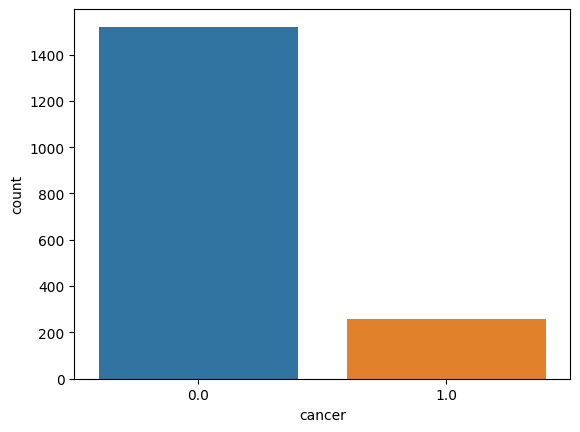

In [17]:
sns.countplot(x=NormDATA['cancer'], label = "Count")

### Correlation Matrix

<Axes: >

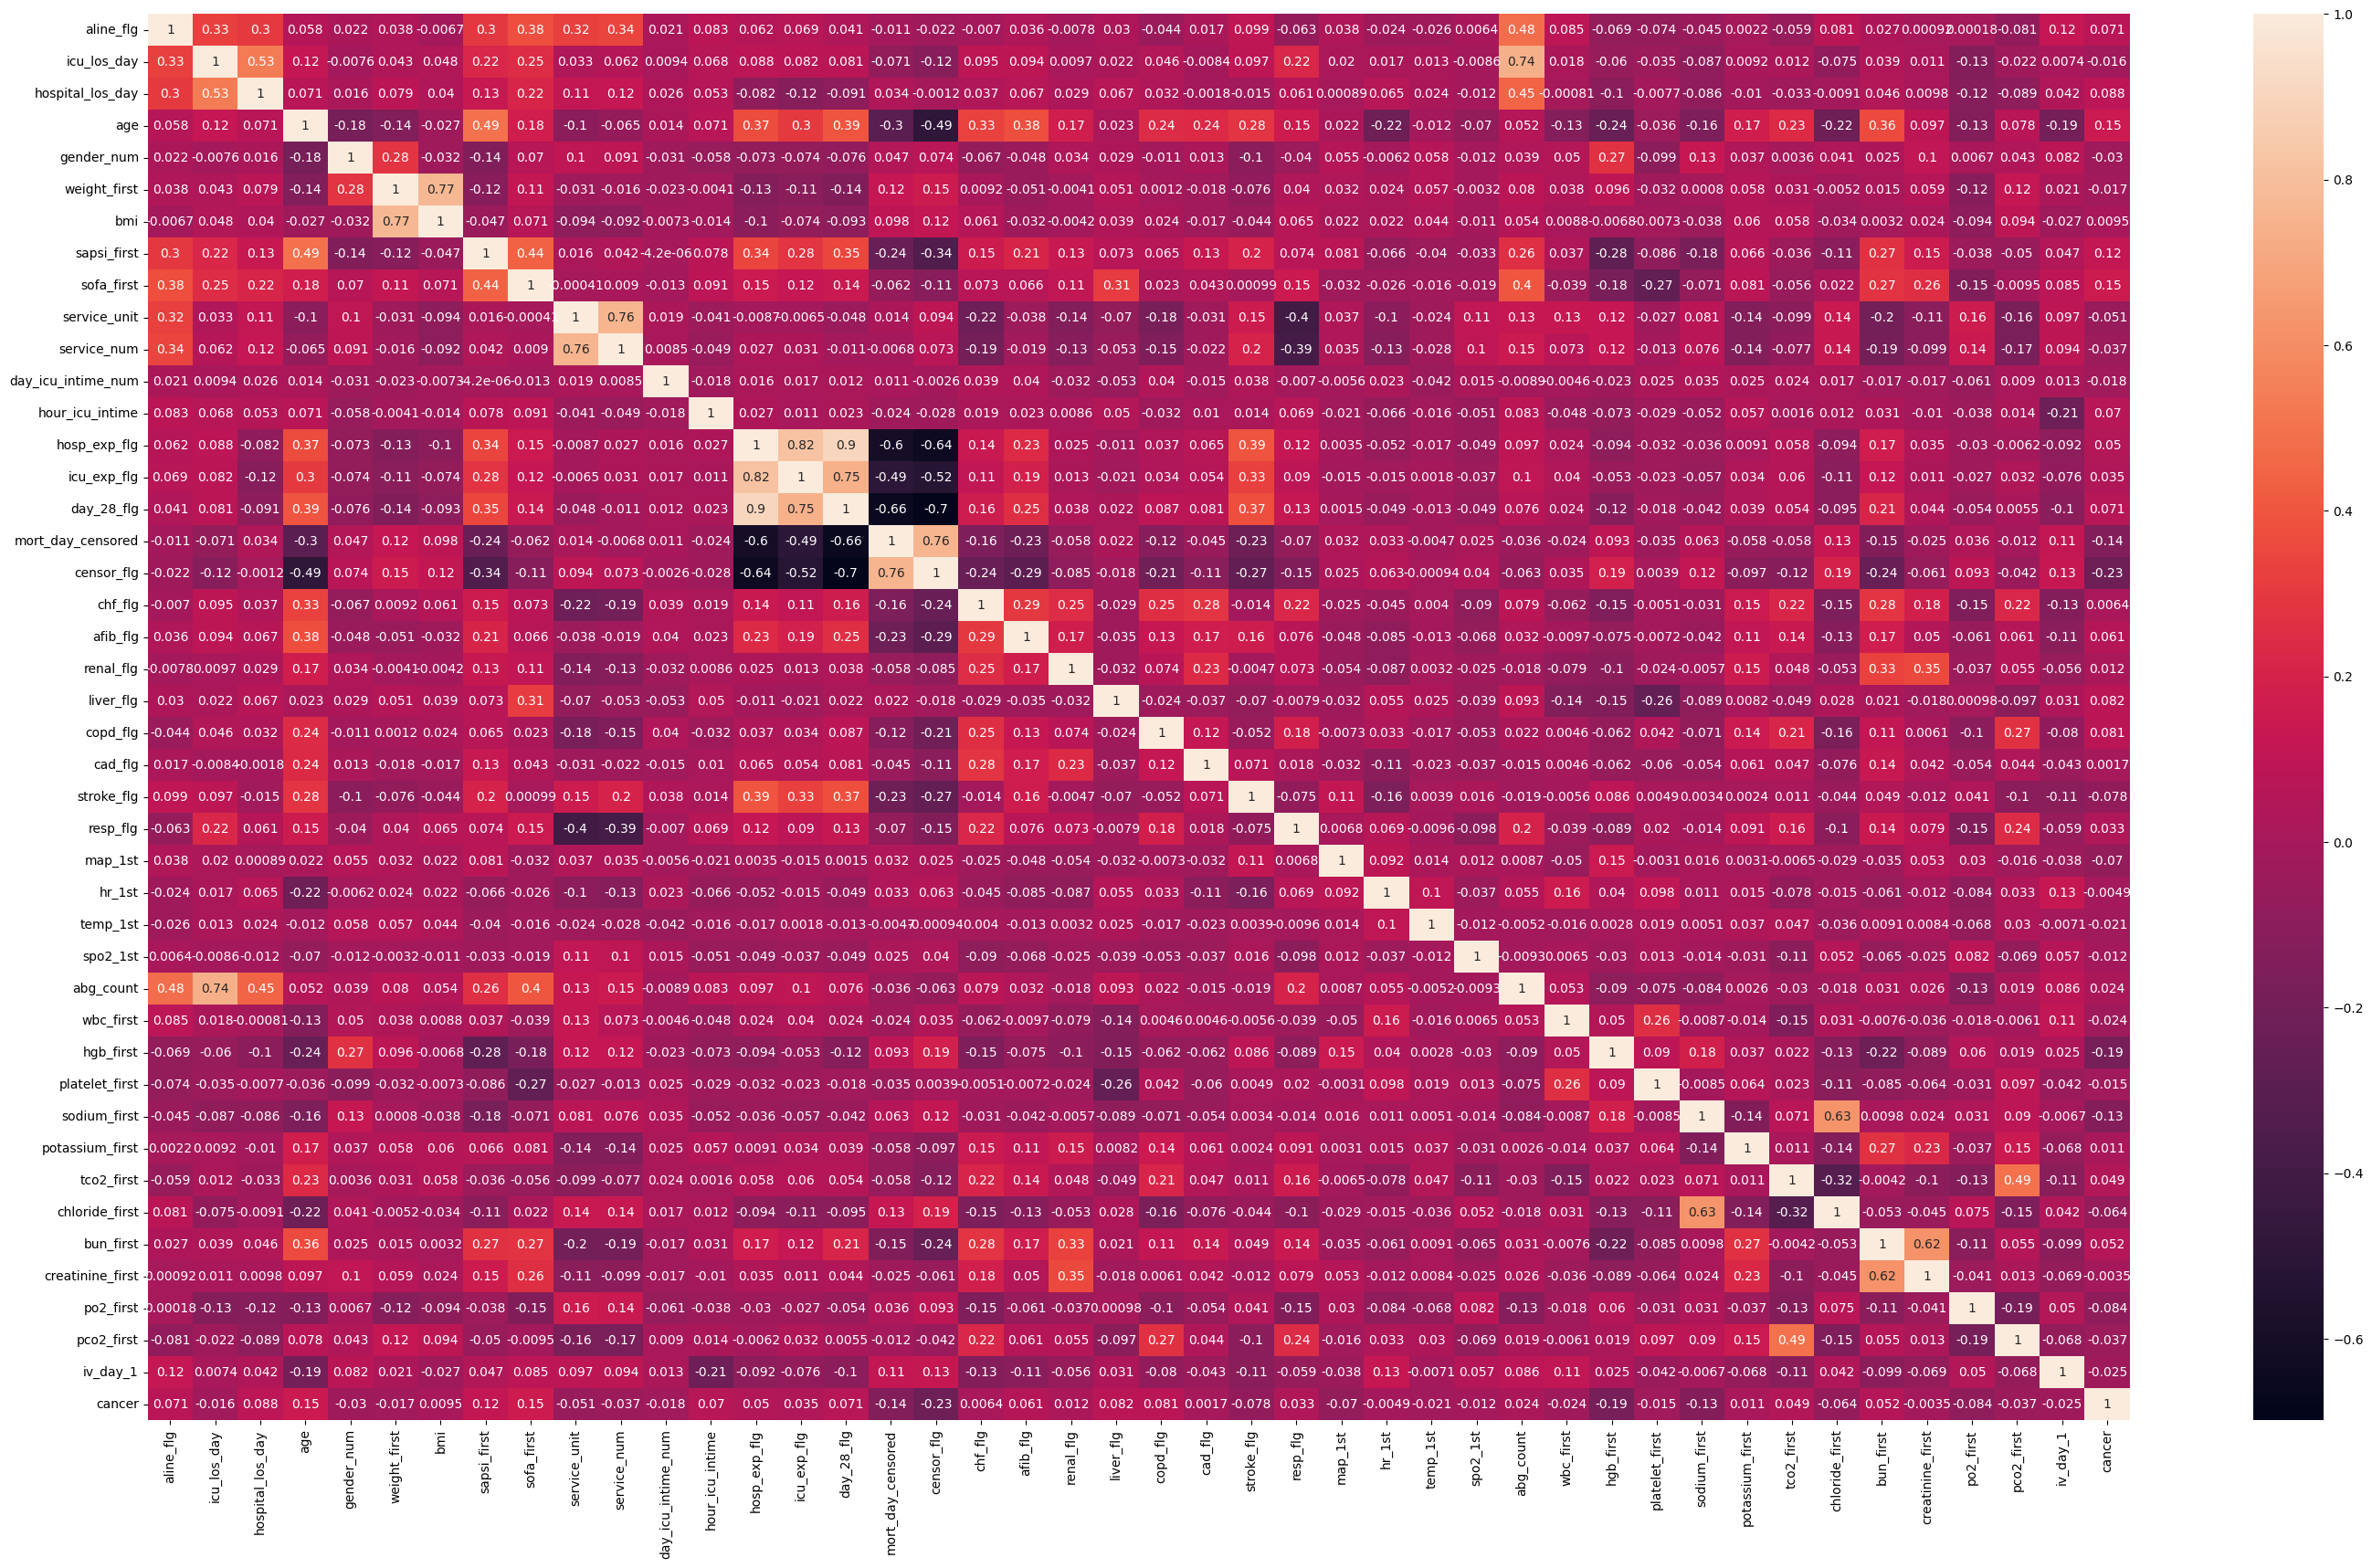

In [18]:
plt.figure(figsize=(35,20))
sns.heatmap(NormDATA.corr(numeric_only=True),annot=True)

### Mapping of the variables most correlated with cancer

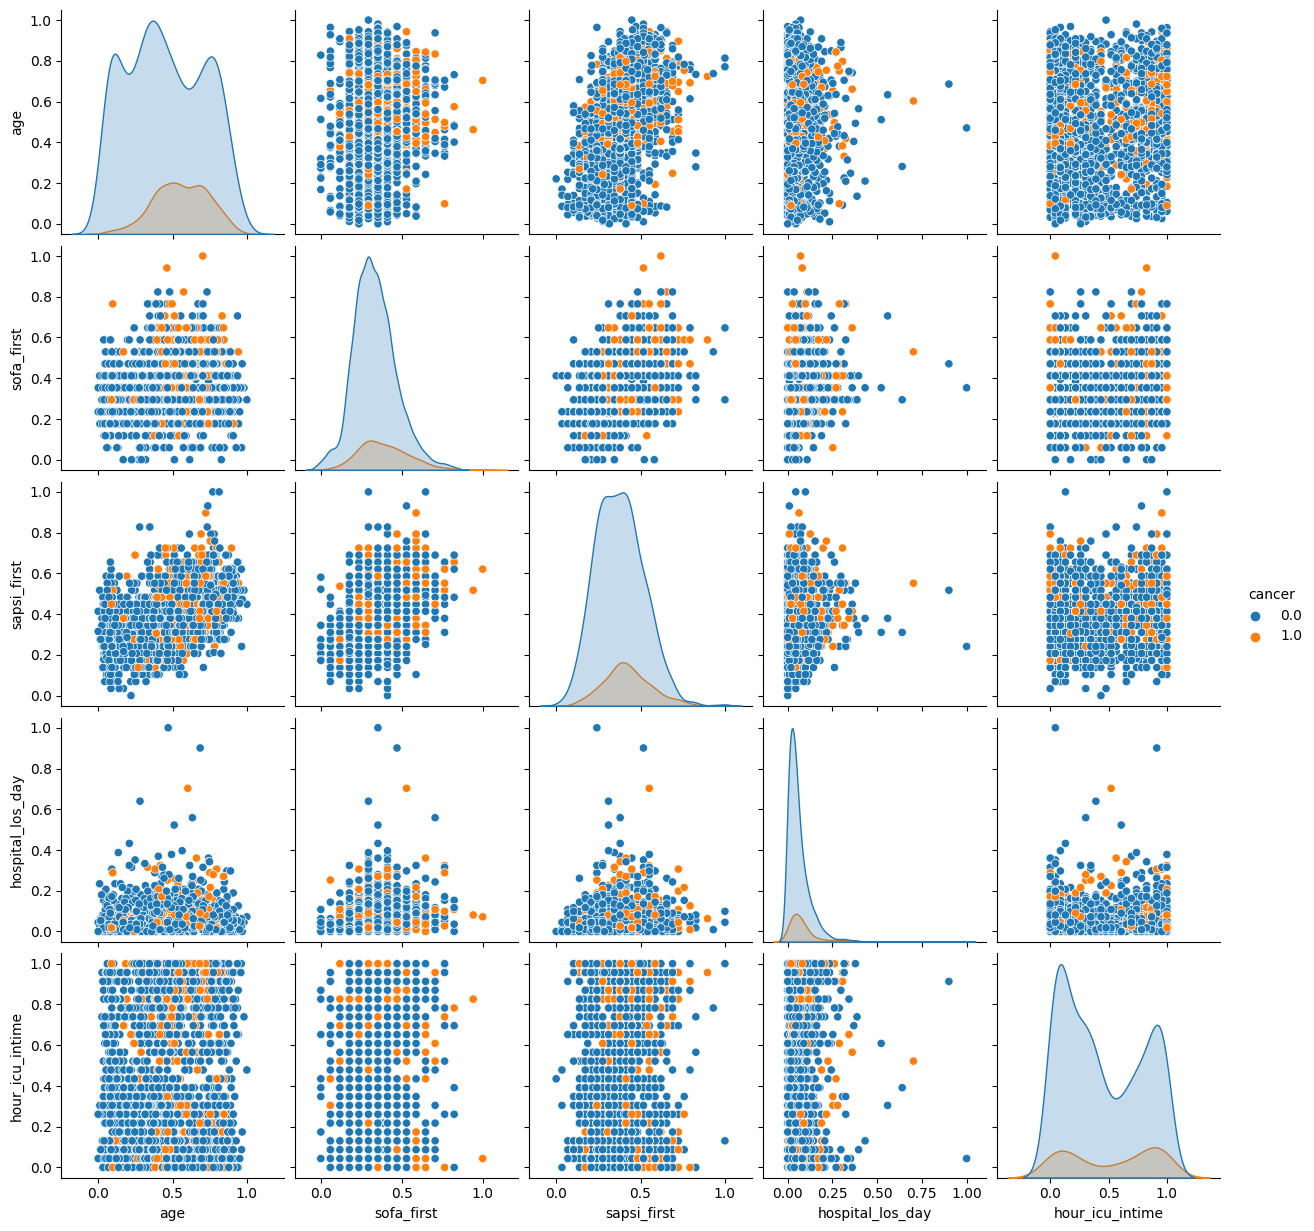

In [19]:
sns.pairplot(NormDATA,hue='cancer',vars=['age','sofa_first','sapsi_first','hospital_los_day','hour_icu_intime'])

# Model Training

In [20]:
x=NormDATA.drop(['cancer'],axis=1)
y=NormDATA['cancer']


# Split data 70%-30% into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x,y.values,test_size=0.30,random_state=5)

print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))

Training Set: 1243, Test Set: 533 



In [21]:
x_train.shape

(1243, 43)

In [22]:
x_test.shape

(533, 43)

In [23]:
y_train.shape

(1243,)

In [24]:
y_test.shape

(533,)

In [25]:
svc_model=SVC(class_weight={0: 1, 1: 4})
svc_model.fit(x_train,y_train)

SVC(class_weight={0: 1, 1: 4})

## Model Evaluation

<Axes: >

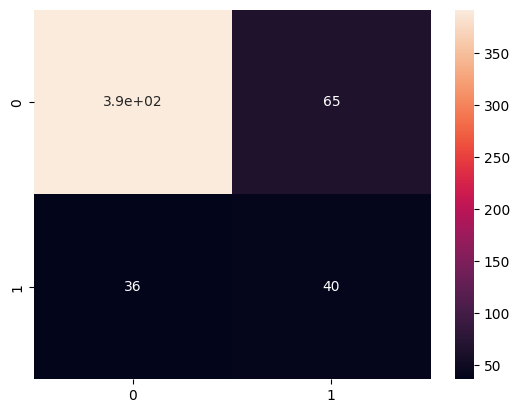

In [26]:
y_predict = svc_model.predict(x_test)
cm=confusion_matrix(y_test,y_predict)
sns.heatmap(cm,annot=True)

In [27]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89       457
         1.0       0.38      0.53      0.44        76

    accuracy                           0.81       533
   macro avg       0.65      0.69      0.66       533
weighted avg       0.84      0.81      0.82       533



## Improve Accuracy

### Searching for C and Gamma parameters, with class weights














In [28]:
param_grid = {'C': np.linspace(-10,10,30), 'gamma': np.linspace(-10,10,30), 'kernel': ['rbf']}

In [29]:
grid = GridSearchCV(SVC(class_weight={0: 1, 1: 5}),param_grid,refit=True,verbose=4)

In [30]:
grid.fit(x_train,y_train)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV 1/5] END ....C=-10.0, gamma=-10.0, kernel=rbf;, score=nan total time=   0.0s
[CV 2/5] END ....C=-10.0, gamma=-10.0, kernel=rbf;, score=nan total time=   0.0s
[CV 3/5] END ....C=-10.0, gamma=-10.0, kernel=rbf;, score=nan total time=   0.0s
[CV 4/5] END ....C=-10.0, gamma=-10.0, kernel=rbf;, score=nan total time=   0.0s
[CV 5/5] END ....C=-10.0, gamma=-10.0, kernel=rbf;, score=nan total time=   0.0s
[CV 1/5] END C=-10.0, gamma=-9.310344827586206, kernel=rbf;, score=nan total time=   0.0s
[CV 2/5] END C=-10.0, gamma=-9.310344827586206, kernel=rbf;, score=nan total time=   0.0s
[CV 3/5] END C=-10.0, gamma=-9.310344827586206, kernel=rbf;, score=nan total time=   0.0s
[CV 4/5] END C=-10.0, gamma=-9.310344827586206, kernel=rbf;, score=nan total time=   0.0s
[CV 5/5] END C=-10.0, gamma=-9.310344827586206, kernel=rbf;, score=nan total time=   0.0s
[CV 1/5] END C=-10.0, gamma=-8.620689655172413, kernel=rbf;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
3375 fits failed out of a total of 4500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

GridSearchCV(estimator=SVC(class_weight={0: 1, 1: 5}),
             param_grid={'C': array([-10.        ,  -9.31034483,  -8.62068966,  -7.93103448,
        -7.24137931,  -6.55172414,  -5.86206897,  -5.17241379,
        -4.48275862,  -3.79310345,  -3.10344828,  -2.4137931 ,
        -1.72413793,  -1.03448276,  -0.34482759,   0.34482759,
         1.03448276,   1.72413793,   2.4137931 ,   3.10344828,
         3.79310345,   4.48275862,   5.17241379,   5.86206897,
         6.5517...
                         'gamma': array([-10.        ,  -9.31034483,  -8.62068966,  -7.93103448,
        -7.24137931,  -6.55172414,  -5.86206897,  -5.17241379,
        -4.48275862,  -3.79310345,  -3.10344828,  -2.4137931 ,
        -1.72413793,  -1.03448276,  -0.34482759,   0.34482759,
         1.03448276,   1.72413793,   2.4137931 ,   3.10344828,
         3.79310345,   4.48275862,   5.17241379,   5.86206897,
         6.55172414,   7.24137931,   7.93103448,   8.62068966,
         9.31034483,  10.        ]),
                         'kernel': ['rbf']},
             verbose=4)

In [31]:
grid.best_params_

{'C': 0.3448275862068968, 'gamma': 10.0, 'kernel': 'rbf'}

In [32]:
grid.best_estimator_

SVC(C=0.3448275862068968, class_weight={0: 1, 1: 5}, gamma=10.0)

In [33]:
grid_predictions= grid.predict(x_test)

## Model Evaluation

<Axes: >

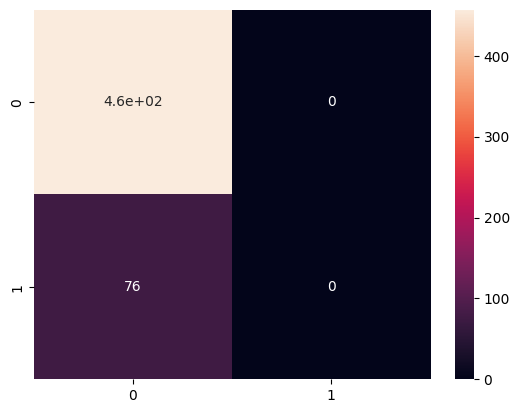

In [34]:
cm=confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm,annot=True)

In [35]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92       457
         1.0       0.00      0.00      0.00        76

    accuracy                           0.86       533
   macro avg       0.43      0.50      0.46       533
weighted avg       0.74      0.86      0.79       533



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Ups! We will follow another path

## Adding synthetic data for training to balance the classes


In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=10)

# Aplicar SMOTE solo en el conjunto de entrenamiento
smote = SMOTE(random_state=10)
X_resampled, Y_resampled = smote.fit_resample(X_train, Y_train)

# Imprimir las formas de los conjuntos antes y después de SMOTE
print("\n")
print("Forma antes de SMOTE:", X_train.shape, Y_train.shape)
print("Forma después de SMOTE:", X_resampled.shape, Y_resampled.shape)




Forma antes de SMOTE: (1420, 43) (1420,)
Forma después de SMOTE: (2418, 43) (2418,)


### Visualization new training data



<Axes: xlabel='cancer', ylabel='count'>

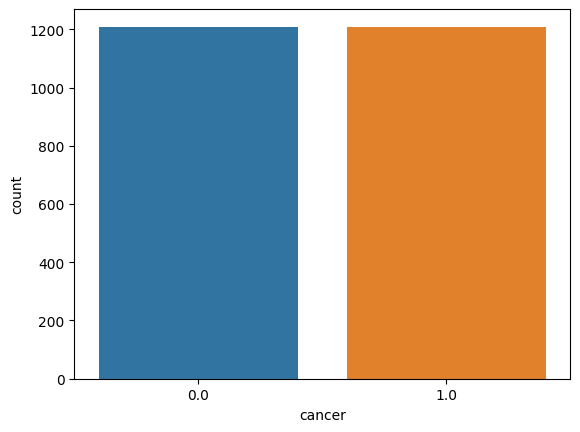

In [37]:
sns.countplot(x=Y_resampled, label = "Count")

<Axes: >

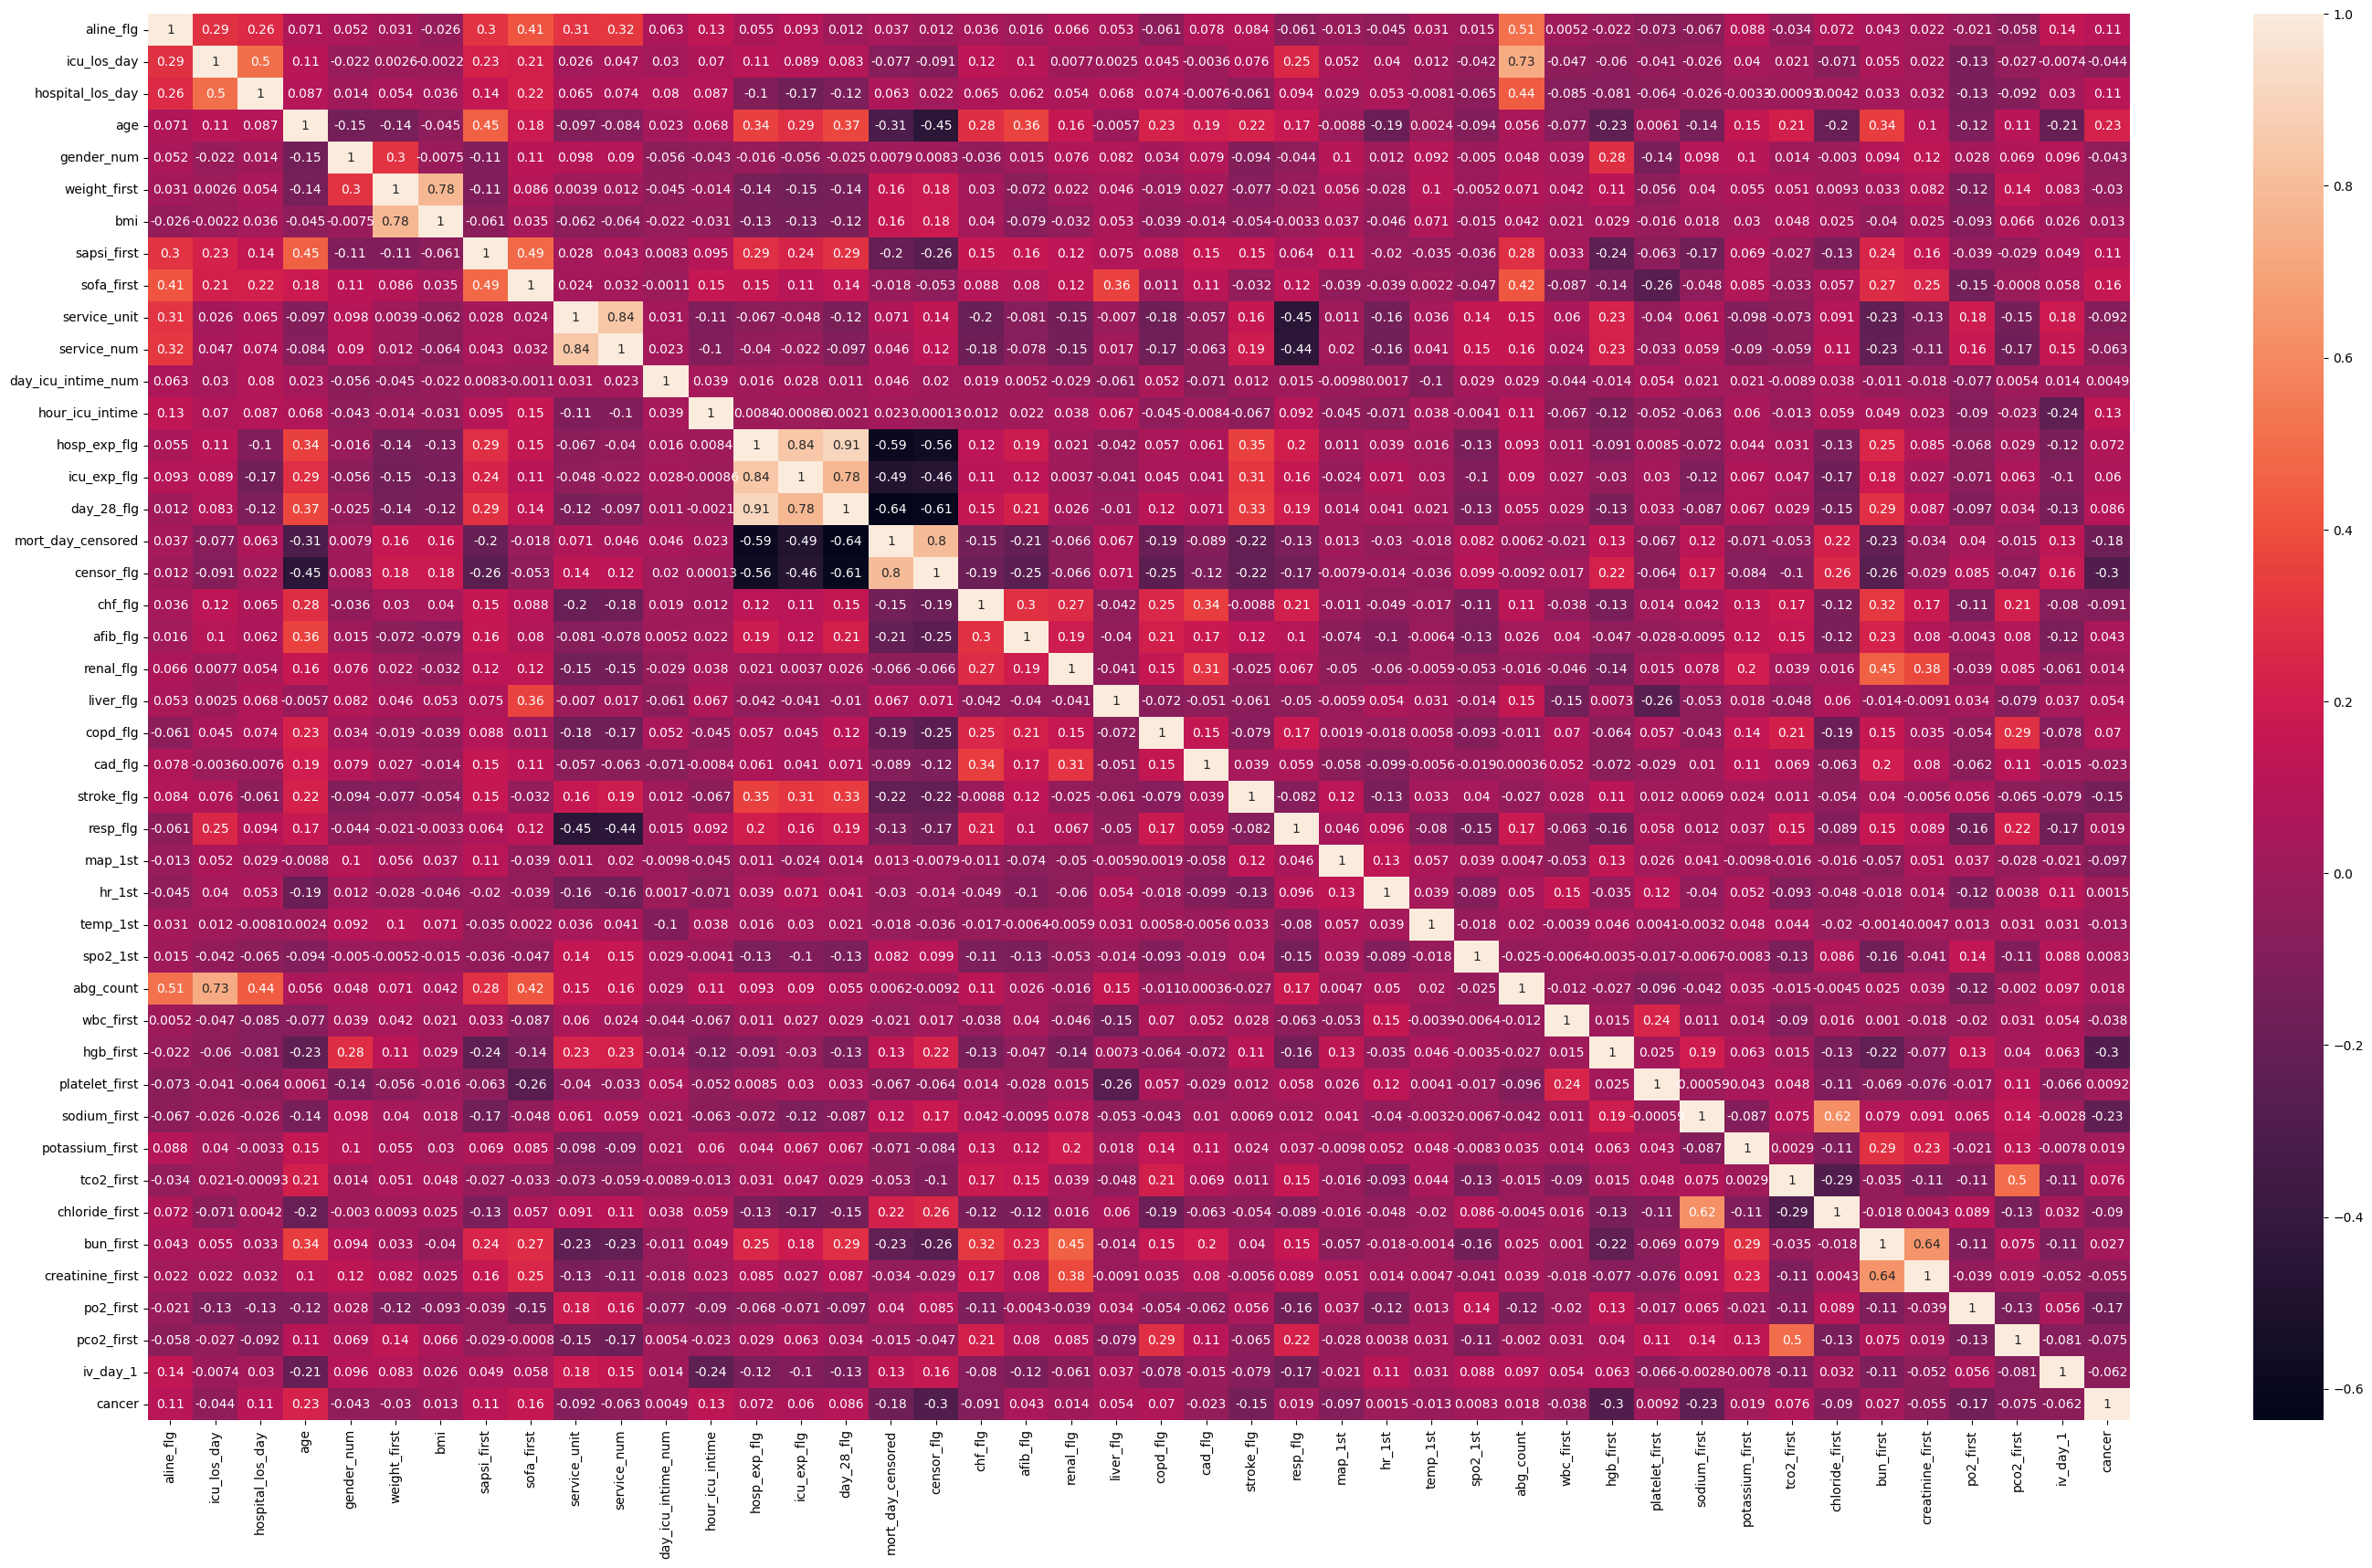

In [38]:
PLOT=pd.DataFrame(np.c_[X_resampled,Y_resampled],columns=np.append(X_resampled.keys(),'cancer'))

plt.figure(figsize=(35,20))
sns.heatmap(PLOT.corr(numeric_only=True),annot=True)

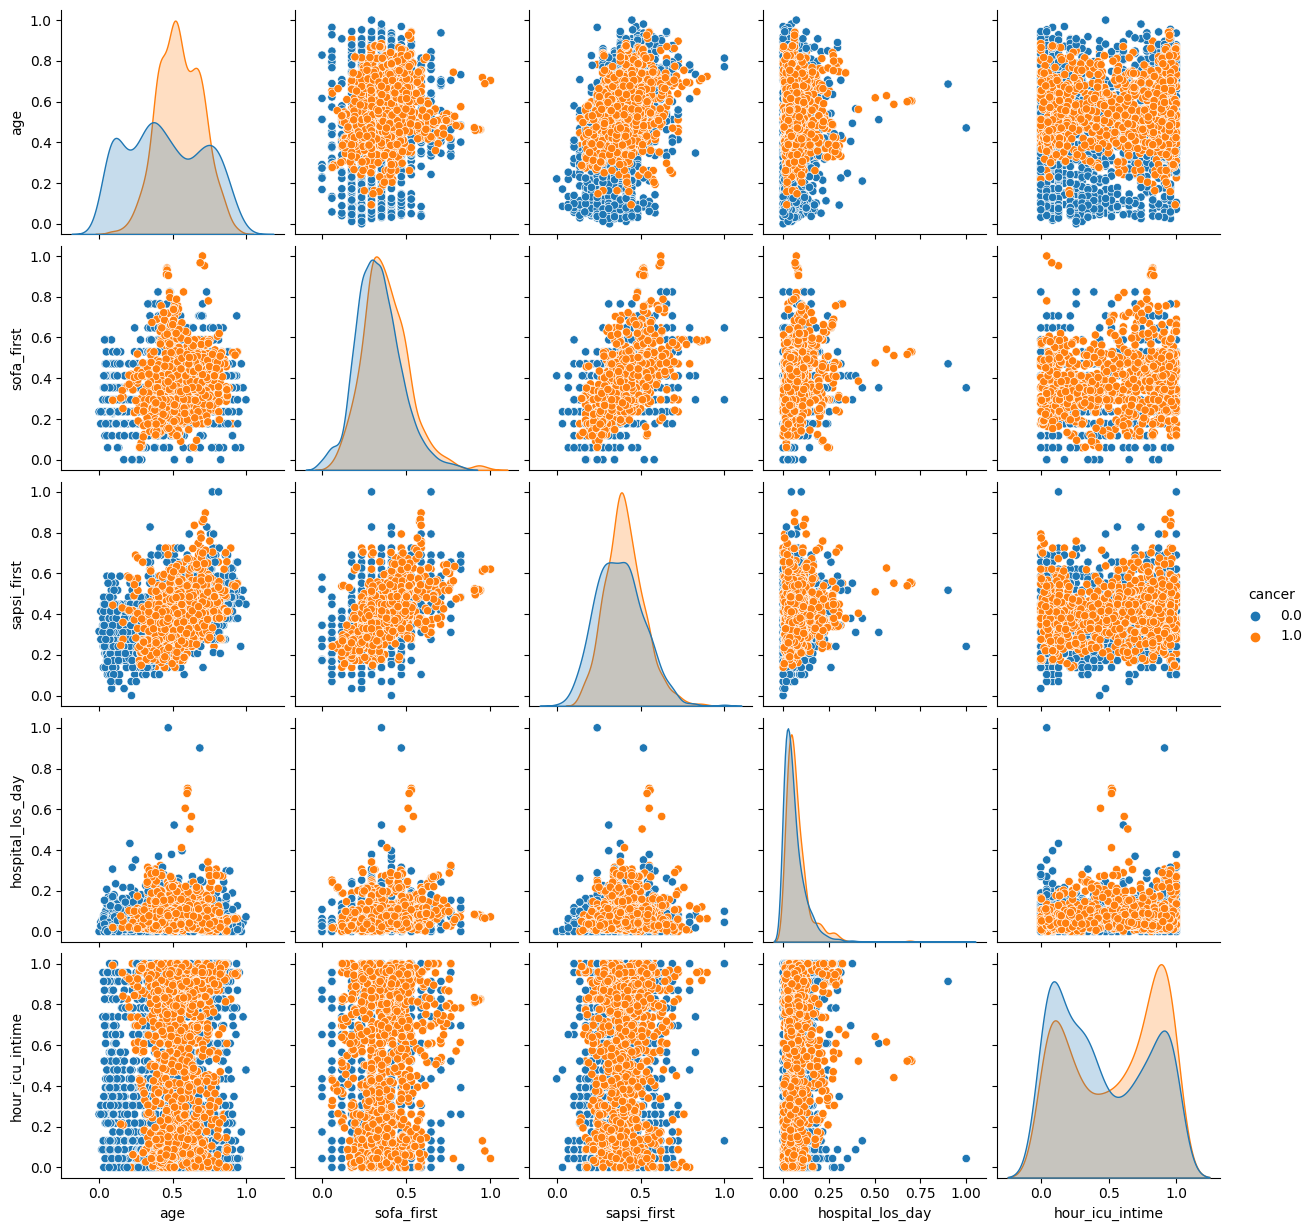

In [39]:
sns.pairplot(PLOT ,hue='cancer' ,vars=['age','sofa_first','sapsi_first','hospital_los_day','hour_icu_intime'])

### Evaluation Model

In [40]:
y_predict = svc_model.predict(x_test)
cm=confusion_matrix(y_test,y_predict)

<Axes: >

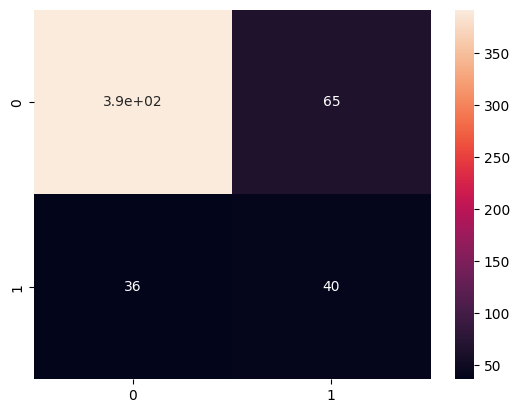

In [41]:
sns.heatmap(cm,annot=True)

# Improving Model

### Searching for C and Gamma parameters, with class weights


In [42]:
param_grid = {'C': np.linspace(0.01,10,5), 'gamma': np.linspace(0.01,10,5), 'kernel': ['rbf']}
MODEL = GridSearchCV(SVC(class_weight={0: 1, 1: 2}),param_grid,refit=True,verbose=4)

MODEL.fit(X_resampled,Y_resampled)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.500 total time=   0.3s
[CV 2/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.500 total time=   0.3s
[CV 3/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.500 total time=   0.3s
[CV 4/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.499 total time=   0.3s
[CV 5/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.501 total time=   0.4s
[CV 1/5] END ..C=0.01, gamma=2.5075, kernel=rbf;, score=0.500 total time=   0.5s
[CV 2/5] END ..C=0.01, gamma=2.5075, kernel=rbf;, score=0.500 total time=   0.5s
[CV 3/5] END ..C=0.01, gamma=2.5075, kernel=rbf;, score=0.500 total time=   0.5s
[CV 4/5] END ..C=0.01, gamma=2.5075, kernel=rbf;, score=0.499 total time=   0.5s
[CV 5/5] END ..C=0.01, gamma=2.5075, kernel=rbf;, score=0.501 total time=   0.5s
[CV 1/5] END ...C=0.01, gamma=5.005, kernel=rbf;, score=0.500 total time=   0.5s
[CV 2/5] END ...C=0.01, gamma=5.005, kernel=rbf

GridSearchCV(estimator=SVC(class_weight={0: 1, 1: 2}),
             param_grid={'C': array([ 0.01  ,  2.5075,  5.005 ,  7.5025, 10.    ]),
                         'gamma': array([ 0.01  ,  2.5075,  5.005 ,  7.5025, 10.    ]),
                         'kernel': ['rbf']},
             verbose=4)

In [43]:
MODEL.best_params_

{'C': 7.5024999999999995, 'gamma': 2.5075, 'kernel': 'rbf'}

In [44]:
MODEL.best_estimator_

SVC(C=7.5024999999999995, class_weight={0: 1, 1: 2}, gamma=2.5075)

### Evaluation Model

<Axes: >

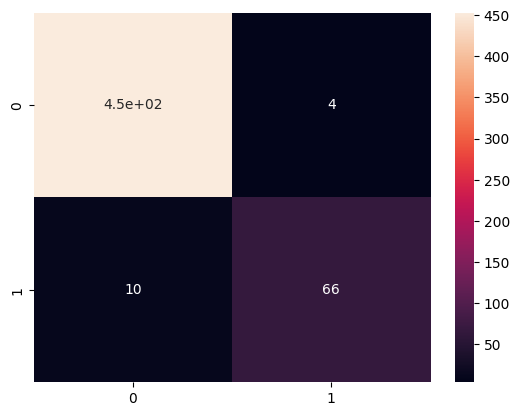

In [45]:
grid_predictions= MODEL.predict(x_test)
cm=confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm,annot=True)

In [46]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       457
         1.0       0.94      0.87      0.90        76

    accuracy                           0.97       533
   macro avg       0.96      0.93      0.94       533
weighted avg       0.97      0.97      0.97       533



## Save the model

In [47]:
dump(MODEL, 'MIMIC_Cancer_Classifier_Model.joblib')

['MIMIC_Cancer_Classifier_Model.joblib']

## Delete the model

In [48]:
del(MODEL)

## Reload the model

In [49]:
Reload_Model = load('MIMIC_Cancer_Classificator.joblib')

# Small Test

## Reload Preprocess

In [50]:
reload_trnsf=joblib.load("MIMIC_Cancer_Classifier_Preprocessing.joblib")
reload_trnsf

{'cleaner': CustomTransform(),
 'imputer': KNNImputer(n_neighbors=7),
 'scaler': MinMaxScaler(),
 'dataframe': DF_Transform()}

## Preprocessing raw data

In [51]:
# Preprocess Step 1
preproc_1 = reload_trnsf['cleaner'].transform(table)
keys=preproc_1.keys()

#Preproces Step 2
preproc_2 = reload_trnsf['imputer'].transform(preproc_1)
preproc_2 = reload_trnsf['dataframe'].transform(preproc_2, keys)

#Preproces Step 3
preproc_3 = reload_trnsf['scaler'].transform(preproc_2)
preproc_3 = reload_trnsf['dataframe'].transform(preproc_3, keys)
display(preproc_3)

aline_flg  icu_los_day  hospital_los_day       age  gender_num  \
0           1.0     0.257030          0.108108  0.681374         1.0   
1           0.0     0.023071          0.000000  0.592638         0.0   
2           0.0     0.085076          0.036036  0.254016         0.0   
3           1.0     0.002884          0.018018  0.349237         0.0   
4           1.0     0.045061          0.036036  0.102012         1.0   
...         ...          ...               ...       ...         ...   
1771        1.0     0.951694          0.270270  0.635117         1.0   
1772        1.0     0.115357          0.027027  0.682229         0.0   
1773        0.0     0.085436          0.018018  0.089607         1.0   
1774        1.0     0.797765          0.198198  0.459474         1.0   
1775        1.0     0.056957          0.081081  0.544414         0.0   

      weight_first       bmi  sapsi_first  sofa_first  service_unit  ...  \
0         0.197715  0.199133     0.413793    0.529412           0.5  ...   
1         0.109842  0.085295     0.236453    0.294118           0.0  ...   
2         0.175747  0.166644     0.448276    0.294118           0.0  ...   
3         0.227718  0.178460     0.620690    0.411765           0.5  ...   
4         0.286467  0.182296     0.517241    0.411765           0.5  ...   
...            ...       ...          ...         ...           ...  ...   
1771      0.204745  0.168434     0.482759    0.470588           0.0  ...   
1772      0.131810  0.133200     0.379310    0.294118           0.5  ...   
1773      0.171353  0.114551     0.448276    0.294118           0.0  ...   
1774      0.414763  0.197167     0.517241    0.529412           0.5  ...   
1775      0.155536  0.141406     0.379310    0.411765           0.0  ...   

      sodium_first  potassium_first  tco2_first  chloride_first  bun_first  \
0         0.550000         0.341772    0.216667        0.563636   0.284672   
1         0.561905         0.330922    0.397619        0.425974   0.123045   
2         0.650000         0.253165    0.250000        0.418182   0.102190   
3         0.566667         0.291139    0.483333        0.400000   0.102190   
4         0.683333         0.189873    0.283333        0.581818   0.058394   
...            ...              ...         ...             ...        ...   
1771      0.500000         0.189873    0.350000        0.400000   0.109489   
1772      0.550000         0.556962    0.333333        0.472727   0.131387   
1773      0.483333         0.278481    0.350000        0.490909   0.182482   
1774      0.533333         0.341772    0.316667        0.381818   0.080292   
1775      0.566667         0.253165    0.016667        0.600000   0.167883   

      creatinine_first  po2_first  pco2_first  iv_day_1  cancer  
0             0.087432   0.284314    0.206667  0.160379     1.0  
1             0.053084   0.301821    0.259048  0.043134     0.0  
2             0.043716   0.450980    0.146667  0.150022     0.0  
3             0.027322   0.202614    0.100000  0.078214     1.0  
4             0.054645   0.183007    0.146667  0.169536     0.0  
...                ...        ...         ...       ...     ...  
1771          0.049180   0.377451    0.180000  0.007198     0.0  
1772          0.043716   0.215686    0.246667  0.020845     1.0  
1773          0.032787   0.430439    0.155238  0.011323     1.0  
1774          0.060109   0.101307    0.153333  0.001565     0.0  
1775          0.076503   0.901961    0.026667  0.314019     0.0  

[1776 rows x 44 columns]

## Generate a random trial

In [52]:
x_trial=preproc_3.drop(['cancer'],axis=1)
y_trial=preproc_3['cancer']


random_num=randint(0,len(x_trial)-1)

data_trial=x_trial.loc[random_num:random_num+1]
label_trial=y_trial.loc[random_num:random_num+1]

print ("Predicted label:", Reload_Model.predict(data_trial))
print ("Groundtruth label:",label_trial.to_numpy())

Predicted label: [0. 1.]
Groundtruth label: [0. 1.]
